# Self KL-divergence for detecting out of distribution data and unsupervised text classification
> Running two models alongside each other for trivial out of distribution detection in production models and side bonus is getting unsupervised text classification

- toc: true 
- badges: true
- comments: true
- tags: [ml, nlp, kldivergence]

> TL;DR. By training two models in the same dataset order with same architecture, same loss, but different initialization, 
> I was able to obtain a consistent out-of-distribution detector by measuring the kl-divergence between model outputs.
> This out-of-distribution measure used on text could lead to unsupervised text classification.


## What's the problem ?

ML models usually are not really capable of predicting how well the data you     
feed them is close to what was in the dataset. It really matters in production 
models as they might make really stupid mistakes just because they are off       
the training set.                             


                     

Let's train a simple mnist model (straight out from pytorch tutorial https://github.com/pytorch/examples/tree/master/mnist)

In [2]:
#hide
!pip install torch torchvision

In [3]:
#collapse
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import os


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def mnist():
    filename = "mnist_cnn.pt"
    # Training settings
    if os.path.exists(filename):
        return
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.expanduser('../data'), train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), filename)
        
# mnist()



In [4]:
#hide
# Notebook specific hack
import sys; sys.argv=['']; del sys
mnist()

In [5]:
#collapse
from torch.distributions import Categorical
from torch.nn.parameter import Parameter
from torchvision import transforms



def attack_simple(model, verbose=False):
    dummy_input = Parameter(torch.rand(1, 1, 28, 28, requires_grad=True))

    lr = 1
    optimizer = optim.Adadelta([dummy_input], lr=lr)
    for i in range(100):
        output = model(dummy_input)
        entropy = Categorical(logits = output).entropy()
        # print(f'Entropy {entropy.item():.2f}')
        optimizer.zero_grad()
        entropy.backward()
        optimizer.step()

    MAX = output[0].exp().max(dim=-1)
    pil_img = transforms.Resize((240, 240))(transforms.ToPILImage()(dummy_input[0]))
    return (MAX.values.item() > 0.8, MAX, pil_img)

def check_attack():
    mnist_model = Net()
    mnist_model.load_state_dict(torch.load('mnist_cnn.pt'))

    success, MAX, pil_img = attack_simple(mnist_model)
    print(f"MNIST Model says : This is a {MAX.indices.item()} with probability {MAX.values.item() * 100:.2f}%")
    display(pil_img)
    success_rate = sum(attack_simple(mnist_model)[0] for i in range(100)) / 100.
    print(f"Success rate {success_rate * 100: .2f}")
    
# check_attack()


MNIST Model says : This is a 2 with probability 99.97%


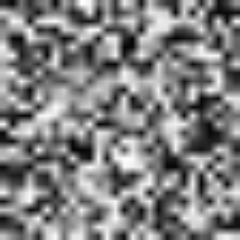

Success rate  100.00


In [6]:
#hide
check_attack()

Then generate an random image for which the model is highly confident yet it's completely absurd. This new image is out of distribution yet the model does not know it. We want to avoid doing such mistakes in production.

## Other approaches


Other out of distribution detector have been proposed. Here is a sample of methods:

- [Likelihood Ratios for Out-of-Distribution Detection](https://arxiv.org/pdf/1906.02845.pdf): Propose to learn 2 distinct models, one "raw", one with perturbation instilled into the dataset, and look at the log likelihood ratio of the two models, claim is that the difference between the two will reflect how "far" input is from the semantic part of the manifold of X. $p(x) = p(x_{background})p(x_{semantic})$, the perturbation needs to lie only on $x_{semantic}$.
- [Out-of-distribution Detection in Classifiers via Generation](https://arxiv.org/pdf/1910.04241.pdf): Propose to use autoencoder (or GANs) to generate a low dimensional representation of the manifold of the dataset X, then perturb X on that representation. Those perturbated examples are trained to become a new "class" of the output of the classifier. 
- [Enhancing the reliability of Out-of-Distribution Image Detection in Neural Networks (Odin)](https://arxiv.org/pdf/1706.02690.pdf): This one uses temperature scaling regarding softmax to generate perturbated input, then look at the probability of the softmax if it passes a threshold. IMO, this paper is interesting as it supposes smoothness properties on In distribution data, and less smooth for out-of-distribution. It does require some examples of out-of-distribution for fitting 3 hyperparameters (temperature, threshold and magnitude of perturbation)
- [Your classifier is secretly an energy based model and you should treat it like one](https://openreview.net/pdf?id=Hkxzx0NtDB): This one adds a new term in the loss to estimate p(x) basically. Multiple ood detectors are proposed, the most efficient being the second derivative of p(x), claiming again that density of p(x) will change more widly in ood space, leading to a good ood detector.

- [WAIC, but Why? Generative Ensembles for Robust Anomaly Detection](https://arxiv.org/pdf/1810.01392.pdf): This paper proposes to use an ensemble of models and look at WAIC criterion to detect OOD. It makes many comparison to VAE and GANs

- [Learning Confidence for Out-of-Distribution Detection in Neural Networks](https://arxiv.org/pdf/1802.04865v1.pdf) : The core idea in this paper is to change the learning loss, to learn confidence as prior task to classification task, a model is allowed to see real label only when it claims it can solve the problem, outputting via another head directly a confidence score. Caveat is that the model might choose to give up and always claim confidence, and another trick is proposed to emphasize the in-distribution vs out-of-distribution by preprocessing inputs to move them towards region of higher confidence. In-distribution tends to move closer to 1 than out-of-distribution. So the direct confidence estimator seems to be *smoother* out-of-distribution than in-distribution, where peaks are more likely to be found.

- [Papers with code](https://paperswithcode.com/task/out-of-distribution-detection): More links on that hopefully

## Our approach

> **Tl;dr : Make two similar models, with two different random initialization, then train them at the same time.
> The ood detector will simply be the a threshold classifier on the KL-divergence between the two outputs.**

The core argument for this approach is that the neural network captures the dataset manifold (which means it will produce "regular" outputs for in dataset items). For the range of possible values it has random values for a random initialization. If that is true, then we train the model, we shift it's output only on the dataset manifold, and not anywhere else. If that assumption is correct, then the 2 models have very low probability of concurring in their output outside of the manifold if they have been initialized differently.

It's quite close to WAIC, *but* the two models need to be trained at the same time. The argument is that is should align gradients during the training phase, leading to more correlation for in-dataset prediction for the models. The argument for this supposes that the lottery ticket hypothesis is true, and adds that lottery ticket is unique (or at least that the class of lottery tickets is very thin, and they all highly correlate to each other). If this is true, then the gradients within the network that correspond to this lottery ticket winner in *both* networks should be the same (or highly correlated).

In order to fix the threshold, we found that simply setting it to be 10x the average kl-divergence obtained on the train dataset worked pretty well. As kl divergence is measured in bits, 10x is a quite large margin. More work could be done to study more closely the behaviour of this self kl-divergence.

## Experiments

### Experiment 1

MNIST attack like failure presented before.




In [6]:
class MultiNet(nn.Module):
    def __init__(self, *models):
        super().__init__()
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        return [model(x) for model in self.models]

    
def train_multi(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = sum(F.nll_loss(output, target) for output in outputs)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test_multi(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += sum(F.nll_loss(output, target, reduction='sum').item() for output in outputs)
            pred = outputs[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def mnist_multi():
    # Training settings
    filename = "mnist_multi_cnn.pt"
    if os.path.exists(filename):
        return
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(os.path.expanduser('../data'), train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model1 = Net()
    model2 = Net()
    model = MultiNet(model1, model2).to(device)

    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_multi(args, model, device, train_loader, optimizer, epoch)
        test_multi(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), filename)
        

# mnist_multi()

In [7]:
#hide
# Notebook specific hack
import sys; sys.argv=['']; del sys
mnist_multi()

In [8]:
from torchvision import datasets
def kl(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            
            loss = 0
            n = 0
            for i in range(len(outputs) - 1):
                for j in range(i + 1, len(outputs)):
                    n += 1
                    loss += 1/2 * (F.kl_div(outputs[i], outputs[j].exp(), reduction='sum').item() + F.kl_div(outputs[j], outputs[i].exp(), reduction='sum').item())
                    
            loss /= n
            test_loss += loss


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, len {} \n'.format(
        test_loss, len(test_loader.dataset)))
    return test_loss

def get_reference_kl():
    multi_model = MultiNet(Net(), Net())
    multi_model.load_state_dict(torch.load('mnist_multi_cnn.pt'))


    test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(os.path.expanduser('../data'), train=False, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ])),
            batch_size=1000, shuffle=True)
    return kl(multi_model, device='cpu', test_loader=test_loader)

# ref_kl_loss = get_reference_kl()
    

In [11]:
#hide
ref_kl_loss = get_reference_kl()



Test set: Average loss: 0.0069, len 10000 



Now we have 2 models capable of detecting digits, we have instantly 3 checks for checking if the output of our model is valid. The 2 models need to be concording (they need to outputs the same digit as an output), they need to have similar kl-divergence, we actually have a reference for the test set, so we know what kind of divergence we should look for, anything 10x more is definitely ood (we could look at the test set distribution for more fine grain estimation). Because kl divergence is asymetric we have 2 values (it's harder for spiked distribution to have another distribution be close in the kl sense, so taking the max of kl-divergence should be used for out-of-distribution.


In [9]:
#collapse
from torch.distributions import Categorical
from torch.nn.parameter import Parameter
from torchvision import transforms

def attack(loss_fn, verbose=True, n=100, lr=1):
    multi_model = MultiNet(Net(), Net())
    multi_model.load_state_dict(torch.load('mnist_multi_cnn.pt'))

    dummy_input = Parameter(torch.rand(1, 1, 28, 28, requires_grad=True))

    optimizer = optim.Adadelta([dummy_input], lr=lr)
    for i in range(n):
        outputs = multi_model(dummy_input)
        
        loss = loss_fn(outputs)
        # print(f'Entropy {entropy.item():.2f}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    MAX1 = outputs[0][0].exp().max(dim=-1)
    MAX2 = outputs[1][0].exp().max(dim=-1)

    kl_loss = F.kl_div(outputs[0], outputs[1].exp(), reduction='batchmean')
    kl_loss2 = F.kl_div(outputs[1], outputs[0].exp(), reduction='batchmean')

    if (kl_loss / ref_kl_loss) > 10 or kl_loss2 / ref_kl_loss > 10 or MAX1.indices.item() != MAX2.indices.item():
        success = False
    else:
        success = MAX1.values.item() > 0.8 and MAX2.values.item() > 0.8
    if verbose:
        print(f"MNIST Model says : This is a {MAX1.indices.item()} with probability {MAX1.values.item() * 100:.2f}%")
        print(f"MNIST Model 2 says : This is a {MAX2.indices.item()} with probability {MAX2.values.item() * 100:.2f}%")

        print(f"KL-divergence is {kl_loss / ref_kl_loss} {kl_loss2 / ref_kl_loss}")

        if success:
            print("ATTACK SUCCEEDED")
        else:
            print("ATTACK FAILED")
        pil_img = transforms.Resize((240, 240))(transforms.ToPILImage()(dummy_input[0]))
        display(pil_img)
    return success
        
        
  


Now if we simply attack the first model like we did earlier, we can see that we can trick it as easily as before. *BUT* the second model, does not get attacked which is to be expected.

MNIST Model says : This is a 3 with probability 99.32%
MNIST Model 2 says : This is a 3 with probability 33.50%
KL-divergence is 587.7392578125 152.96902465820312
ATTACK FAILED


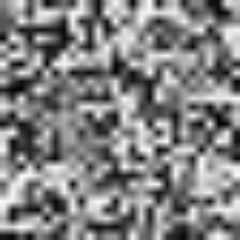

In [12]:
def loss(outputs):
    entropy = Categorical(logits = outputs[0]).entropy()
    
    loss = entropy
    return loss

_ = attack(loss)


Even if we try a smarter and attack __both__ models at the same time, we can't succeed at a consistent rate. Be warned, it will succeed sometimes, just not consistently.

MNIST Model says : This is a 1 with probability 11.50%
MNIST Model 2 says : This is a 7 with probability 11.48%
KL-divergence is 0.474844753742218 0.47643253207206726
ATTACK FAILED


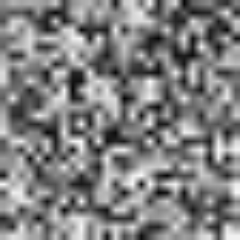

In [11]:
def loss(outputs):
    entropy1 = Categorical(logits = outputs[0]).entropy()
    entropy2 = Categorical(logits = outputs[1]).entropy()

    kl_loss1 = F.kl_div(outputs[0], outputs[1].exp(), reduction='batchmean')
    kl_loss2 = F.kl_div(outputs[1], outputs[0].exp(), reduction='batchmean')

    distance = F.mse_loss(outputs[0], outputs[1])

    loss = entropy1 + entropy2  + kl_loss1 + kl_loss2 + distance
    return loss
    
_ = attack(loss)
    

Be warned, it will succeed sometimes, just not consistently. For comparison, the first attack succeeds with close to 100% (we couldn't make it fail). Actually because we have 10 classes, and if we supposed out-of-distribution probability distribution is uniformly random, it should be something close to 10%, when our initial random image finds a place where the 2 models intersect on the same digit. 

In [12]:
def loss(outputs):
    entropy1 = Categorical(logits = outputs[0]).entropy()
    entropy2 = Categorical(logits = outputs[1]).entropy()

    kl_loss1 = F.kl_div(outputs[0], outputs[1].exp(), reduction='batchmean')
    kl_loss2 = F.kl_div(outputs[1], outputs[0].exp(), reduction='batchmean')

    distance = F.mse_loss(outputs[0], outputs[1])

    loss = entropy1 + entropy2  + kl_loss1 + kl_loss2 + distance
    return loss
    
def attack_rate():
    attacks = []
    for i in range(100):
        success = attack(loss, verbose=False, n=200, lr=0.1)
        if success:
            print("F", end='')
        else:
            print(".", end='')
        attacks.append(success)

    print('')
    print(f"Attack success rate {sum(attacks)/len(attacks) * 100:.2f}%")

# attack_rate()
    

In [ ]:
#hide
attack_rate()

The actual attack range seems to stagnate at around 0% (30% if we remove the confidence rate > 80%) with various learning rates and attack steps. There probably are better strategies to attack, this, but the main point is that it became __harder__.

### Experiment 2

Now let's test this on common ood detection for classic datasets. We will add ood detection for the train dataset, just to check that we don't *exclude* too much of the original dataset. Datasets used will be MNIST, FashionMNIST

In [9]:
#collapse
from torchvision.datasets import MNIST, Omniglot, FashionMNIST
from torchvision import transforms
import os


def dataset_multi(dataset_cls, filename, model, transform):
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1e-2, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        dataset_cls('../data', train=True, download=True,
                       transform=transform),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
                dataset_cls('../data', train=False, download=True,
                               transform=transform), batch_size = args.test_batch_size)



    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.CyclicLR(                             
          optimizer, base_lr=0, max_lr=args.lr, cycle_momentum=False, step_size_up=200                    )
    for epoch in range(1, args.epochs + 1):
        train_multi(args, model, device, train_loader, optimizer, epoch)
        test_multi(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), filename)


def run_datasets(create_model, suffix):
    datasets = [MNIST, FashionMNIST]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for dataset_cls in datasets:
        filename = f'{dataset_cls.__name__}{suffix}.pt'

        if os.path.exists(filename):
            continue

        model = create_model().to(device)

        transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                                    ])
        dataset_multi(dataset_cls, filename, model, transform)

        
def create_model():
    model1 = Net()
    model2 = Net()
    model = MultiNet(model1, model2)
    return model

# run_datasets(create_model, suffix='')


In [10]:
#hide
# Notebook specific hack
import sys; sys.argv=['']; del sys
run_datasets(create_model, suffix='')


In [11]:
from sklearn.metrics import roc_auc_score

In [12]:
def test_datasets(model_arch, suffix):
    datasets = [MNIST, FashionMNIST]

    batch_size = 500
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for dataset_cls in datasets:
        filename = f'{dataset_cls.__name__}{suffix}.pt'
        model_arch.load_state_dict(torch.load(filename))

        model = model_arch
        test_loader = torch.utils.data.DataLoader(
                dataset_cls('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
             ])), batch_size=batch_size)
        ref_kl_loss = kl(model, device, test_loader)
        print("Ref loss", ref_kl_loss)
        
        all_labels = []
        all_scores = []
        for dataset_cls2 in datasets:
            test_loader2 = torch.utils.data.DataLoader(
                dataset_cls2('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
             ])),batch_size=batch_size, shuffle=True)
            
            
            OOD = 0
            for data, target in test_loader2:
                outputs = model(data.to(device))
                kl_loss = torch.max(F.kl_div(outputs[0], outputs[1].exp(), reduction='none'),  F.kl_div(outputs[1], outputs[0].exp(), reduction='none'))
                kl_loss = kl_loss.sum(dim=-1)
                
                similar = outputs[0].argmax(dim=-1) == outputs[1].argmax(dim=-1)
                
                normed = kl_loss / ref_kl_loss
                
                kl_anomaly = normed > 10
                non_concordant = similar == False
                
                out_of_distrib = sum(kl_anomaly | non_concordant)
                
                N = normed.shape[0]
                boolean = dataset_cls2 != dataset_cls
                all_labels.extend([boolean] * N)
                all_scores.extend(normed.tolist())
                
                
                OOD += out_of_distrib
            print(f"Trained on {dataset_cls.__name__} we detected on {dataset_cls2.__name__} {OOD}/{len(test_loader2.dataset)} ({float(OOD)/len(test_loader2.dataset) * 100:.2f}%) out of distribution")
                   
        auc = roc_auc_score(all_labels, all_scores)
        print(f"AUC for {dataset_cls.__name__} : {auc}")

def exp_2():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MultiNet(Net(), Net()).to(device)
    test_datasets(model, suffix='')
    
# exp_2()

In [19]:
#hide
exp_2()


Test set: Average loss: 0.0204, len 10000 

Ref loss 0.0204180196672678
Trained on MNIST we detected on MNIST 350/10000 (3.50%) out of distribution
Trained on MNIST we detected on FashionMNIST 7334/10000 (73.34%) out of distribution
AUC for MNIST : 0.9692911949999999

Test set: Average loss: 0.0490, len 10000 

Ref loss 0.0490430459022522
Trained on FashionMNIST we detected on MNIST 6141/10000 (61.41%) out of distribution
Trained on FashionMNIST we detected on FashionMNIST 1040/10000 (10.40%) out of distribution
AUC for FashionMNIST : 0.8571711399999999


So we can see that we achieve, with no tuning whatsoever a decent out of distribution detector. We seem to achieve much better AUROC on MNIST, probably because the in-distribution learning seems to be much better (99% test accuracy vs 92% for fastionMNIST). So to False positives for fashionMNIST probably come from this hard to learn in-distribution. Some fine tuning needs to be done to get better results. We also have to keep in mind, that the models to learn this are quite small (2M parameters but only 2 convolution layers) so the lottery hypothesis validity for such a network might be questionned.

### Experiment 2 bis

Same experiment but with fine tuned, larger networks on the same datasets 

In [13]:
from torchvision.models.resnet import ResNet, BasicBlock
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return F.log_softmax(super(MnistResNet, self).forward(x), dim=-1)

def run_datasets_res():
    datasets = [MNIST, FashionMNIST]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for dataset_cls in datasets:
        filename = f'{dataset_cls.__name__}_resnet.pt'

        if os.path.exists(filename):
            continue
            
        
        multi_res = MultiNet(MnistResNet(), MnistResNet()).to(device)
        
        transform = transforms.Compose([ transforms.Resize((224, 224)),transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

        dataset_multi(dataset_cls, filename, multi_res, transform)
        
def test_datasets_bis(model_arch):
    datasets = [MNIST, FashionMNIST]

    batch_size = 10
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for dataset_cls in datasets:
        filename = f'{dataset_cls.__name__}_resnet.pt'
        model_arch.load_state_dict(torch.load(filename))

        model = model_arch
        test_loader = torch.utils.data.DataLoader(
                dataset_cls('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
             ])), batch_size=batch_size)
        ref_kl_loss = kl(model, device, test_loader)
        print("Ref loss", ref_kl_loss)
        
        all_labels = []
        all_scores = []
        for dataset_cls2 in datasets:
            test_loader2 = torch.utils.data.DataLoader(
                dataset_cls2('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
             ])),batch_size=batch_size, shuffle=True)
            
            
            OOD = 0
            for data, target in test_loader2:
                outputs = model(data.to(device))
                kl_loss = torch.max(F.kl_div(outputs[0], outputs[1].exp(), reduction='none'),  F.kl_div(outputs[1], outputs[0].exp(), reduction='none'))
                kl_loss = kl_loss.sum(dim=-1)
                
                similar = outputs[0].argmax(dim=-1) == outputs[1].argmax(dim=-1)
                
                normed = kl_loss / ref_kl_loss
                
                kl_anomaly = normed > 10
                non_concordant = similar == False
                
                out_of_distrib = sum(kl_anomaly | non_concordant)
                
                N = normed.shape[0]
                boolean = dataset_cls2 != dataset_cls
                all_labels.extend([boolean] * N)
                all_scores.extend(normed.tolist())
                
                
                OOD += out_of_distrib
            print(f"Trained on {dataset_cls.__name__} we detected on {dataset_cls2.__name__} {OOD}/{len(test_loader2.dataset)} ({float(OOD)/len(test_loader2.dataset) * 100:.2f}%) out of distribution")
                   
        auc = roc_auc_score(all_labels, all_scores)
        print(f"AUC for {dataset_cls.__name__} : {auc}")

        
def exp_2_bis():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    multi_res = MultiNet(MnistResNet(), MnistResNet()).to(device)
    test_datasets_bis(multi_res)

# run_datasets_res()
# exp_2_bis()


In [25]:
#hide
# Notebook specific hack
import sys; sys.argv=['--batch-size=16', '--test-batch-size=250']; del sys
run_datasets_res()



In [15]:
#hide
exp_2_bis()


Test set: Average loss: 0.0286, len 10000 

Ref loss 0.02861522503466085
Trained on MNIST we detected on MNIST 342/10000 (3.42%) out of distribution
Trained on MNIST we detected on FashionMNIST 9416/10000 (94.16%) out of distribution
AUC for MNIST : 0.9919594199999999

Test set: Average loss: 0.1100, len 10000 

Ref loss 0.10995317642445443
Trained on FashionMNIST we detected on MNIST 8693/10000 (86.93%) out of distribution
Trained on FashionMNIST we detected on FashionMNIST 812/10000 (8.12%) out of distribution
AUC for FashionMNIST : 0.96639897


### Experiment 3

Check that two identical networks (same initalization) actually don't work. It's just a sanity check. We should obtain always kl_div = 0 no matter where we are in the input space.

In [16]:
def create_same_model():
    model1 = Net()
    model = MultiNet(model1, model1)
    return model

def exp_3():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    run_datasets(create_same_model, suffix='_exp3')
        
    test_datasets(create_same_model().to(device), suffix='_exp3')
    
# exp_3()

In [29]:
#hide
exp_3()


Test set: Average loss: -0.0000, len 10000 

Ref loss -5.8904380694002614e-09
Trained on MNIST we detected on MNIST 936/10000 (9.36%) out of distribution
Trained on MNIST we detected on FashionMNIST 1036/10000 (10.36%) out of distribution
AUC for MNIST : 0.6250013000000001

Test set: Average loss: -0.0000, len 10000 

Ref loss -1.0612055575620616e-08
Trained on FashionMNIST we detected on MNIST 4/10000 (0.04%) out of distribution
Trained on FashionMNIST we detected on FashionMNIST 1/10000 (0.01%) out of distribution
AUC for FashionMNIST : 0.555029875


### Experiment 4

Run this method with 2, 3, 4, and so on models. We should get exponential improved accuracy, if the random behavious for out-of-distribution for models is correct.

In [23]:
def create_n_model(n):
    models = [Net() for i in range(n)]
    model = MultiNet(*models)
    return model

def test_datasets_4(model_arch, suffix):
    datasets = [MNIST, FashionMNIST]

    batch_size = 100
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for dataset_cls in datasets:
        filename = f'{dataset_cls.__name__}{suffix}.pt'
        model_arch.load_state_dict(torch.load(filename))

        model = model_arch
        test_loader = torch.utils.data.DataLoader(
                dataset_cls('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
             ])), batch_size=batch_size)
        ref_kl_loss = kl(model, device, test_loader)
        print("Ref loss", ref_kl_loss)
        
        all_labels = []
        all_scores = []
        for dataset_cls2 in datasets:
            test_loader2 = torch.utils.data.DataLoader(
                dataset_cls2('../data', train=False, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
             ])),batch_size=batch_size, shuffle=True)
            
            
            OOD = 0
            for data, target in test_loader2:
                outputs = model(data.to(device))
                
                kl_losses = []
                for i in range(len(outputs) - 1):
                    for j in range(i + 1, len(outputs)):
                        kl_losses.append(F.kl_div(outputs[i], outputs[j].exp(), reduction='none'))
                        kl_losses.append(F.kl_div(outputs[j], outputs[i].exp(), reduction='none'))
                        
                kl_loss = torch.stack(kl_losses, dim=0).max(dim=0).values
                kl_loss = kl_loss.sum(dim=-1)
                
                similar = outputs[0].argmax(dim=-1) == outputs[1].argmax(dim=-1)
                
                normed = kl_loss / ref_kl_loss
                
                kl_anomaly = normed > 10
                non_concordant = similar == False
                
                out_of_distrib = sum(kl_anomaly | non_concordant)
                
                N = normed.shape[0]
                boolean = dataset_cls2 != dataset_cls
                all_labels.extend([boolean] * N)
                all_scores.extend(normed.tolist())
                
                
                OOD += out_of_distrib
            print(f"Trained on {dataset_cls.__name__} we detected on {dataset_cls2.__name__} {OOD}/{len(test_loader2.dataset)} ({float(OOD)/len(test_loader2.dataset) * 100:.2f}%) out of distribution")
                   
        auc = roc_auc_score(all_labels, all_scores)
        print(f"AUC for {dataset_cls.__name__} : {auc}")


def exp_4():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for n in [2, 4, 8]:
        print('=' * 20)
        print(f"N = {n}")
        run_datasets(lambda: create_n_model(n), suffix=f'_exp4_{n}')
        test_datasets_4(create_n_model(n).to(device), suffix=f'_exp4_{n}')
    
# exp_4()

In [24]:
#hide
exp_4()

N = 2

Test set: Average loss: 0.0221, len 10000 

Ref loss 0.022054713488323614
Trained on MNIST we detected on MNIST 348/10000 (3.48%) out of distribution
Trained on MNIST we detected on FashionMNIST 7453/10000 (74.53%) out of distribution
AUC for MNIST : 0.96813343

Test set: Average loss: 0.0563, len 10000 

Ref loss 0.05634785660505295
Trained on FashionMNIST we detected on MNIST 7025/10000 (70.25%) out of distribution
Trained on FashionMNIST we detected on FashionMNIST 1026/10000 (10.26%) out of distribution
AUC for FashionMNIST : 0.8957392850000001
N = 4

Test set: Average loss: 0.0267, len 10000 

Ref loss 0.02668519279870622
Trained on MNIST we detected on MNIST 572/10000 (5.72%) out of distribution
Trained on MNIST we detected on FashionMNIST 9007/10000 (90.07%) out of distribution
AUC for MNIST : 0.9743065499999999

Test set: Average loss: 0.0542, len 10000 

Ref loss 0.054210807734727834
Trained on FashionMNIST we detected on MNIST 8587/10000 (85.87%) out of distribution
Tr

Seems not to be working too great, we ARE improving AUC. Not by a strong margin, it is probably just that we are having a better approximator of our metric by ensembling.

### Experiment 5

Test on a larger output space, like CIFAR-100 and SVHN, to check that part of the limits are actually due to small number of output classes
for MNIST/FashionMNIST
Other idea is to test on Transformers. Early experiment seems to show that we can use that idea to detect different language within text with just the kl_div used as a distance.

Found French book within english books dataset, AND english paragraphs *within* this french book.
Needs some work to clean this experiment

- Show that small network trained on a single english book enables to detect different languages
  or different patterns of writing (old english, irish, french, or event dictionnaries)
- The detection is super fined grained capable of detecting english within a French book.

For brevity, we won't include training code. We just trained a simple transformer (6 layers deep) on a english text and checked our metric on some other texts.

![title](images/self-kl-train-eng.png)
![title](images/self-kl-test-eng.png)
![title](images/self-kl-test-fr.png)

### Experiment 6

Need to test with various training schemes, regularization schemes (dropout, batchnorm, l2 penalization) and so on. We should find that the smoother in-distribution our models behave the more this method should work. Hopefully test accuracy *should* be a good smoothness proxy.

## Limits

The pros for this method are that:
 - It's super simple to implement, and only costs a constant factor in training time.
 - You could also extend this to 3, 4 side models, and it *should* improve robustness exponentially if the random factors are correct. If we keep this number small, it will still be constant cost factor.
 - It does *not* require a perturbation model for input data, which in itself is subject to fine-tuning.


The cons is that:
- It does not work so well on low dimensional output spaces. 
- It seems other methods have better results than this one.
- It only works for models that output probability distributions (hard to extend to object detection, generation and other tasks)

 




## Future Work

There is a lot more experiments necessary to verify that the hypothesis in favor of that approach hold. Try to find ways to implement that in other tasks. How to improve out-of-distribution detection.